In [70]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [71]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [72]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-13 15:30:42,981 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-13 15:30:42,998 INFO: Initializing external client
2025-11-13 15:30:42,998 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-13 15:30:44,411 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272015


In [73]:
# Retrieve feature groups (Version 2 för del C!)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [ ]:
# Select features for training data, (including features for part C).
selected_features = air_quality_fg.select(['pm25', 'date', 'lagged_aq_1_day', 'lagged_aq_2_days', 'lagged_aq_3_days']).join(weather_fg.select_features(), on=['city'])

2025-11-13 15:33:07,636 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.84s) 


,pm25,date,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,1.140000,2019-12-09 00:00:00+00:00,NaN,NaN,NaN,4.438917,5.100000,22.768396,246.089539
1,1.200000,2019-12-10 00:00:00+00:00,1.140000,NaN,NaN,-4.140250,0.900000,19.083395,276.084564
2,2.000000,2019-12-11 00:00:00+00:00,1.200000,1.140000,NaN,2.624333,3.200000,29.723444,194.278061
3,18.389999,2019-12-12 00:00:00+00:00,2.000000,1.200000,1.140000,2.586834,4.900000,15.484185,180.472855
4,10.950000,2019-12-13 00:00:00+00:00,18.389999,2.000000,1.200000,2.551417,2.400000,17.782686,143.605789
5,7.260000,2019-12-14 00:00:00+00:00,10.950000,18.389999,2.000000,3.251417,9.299999,19.083395,140.838547
6,2.580000,2019-12-15 00:00:00+00:00,7.260000,10.950000,18.389999,3.141001,1.800000,12.397806,158.689865
7,1.710000,2019-12-16 00:00:00+00:00,2.580000,7.260000,10.950000,2.907667,4.000000,20.304129,238.335480
8,5.390000,2019-12-17 00:00:00+00:00,1.710000,2.580000,7.260000,3.534750,2.600000,16.923830,222.523422
9,1.080000,2019-12-18 00:00:00+00:00,5.390000,1.710000,2.580000,1.549333,16.000000,23.177401,293.558075


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [97]:
#Version 2 för del C

feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=3,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272015/fs/1258614/fv/air_quality_fv/version/3


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [98]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [99]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.04s) 


In [100]:
X_train

,date,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2019-12-09 00:00:00+00:00,NaN,NaN,NaN,4.438917,5.1,22.768396,246.089539
1,2019-12-10 00:00:00+00:00,1.140000,NaN,NaN,-4.140250,0.9,19.083395,276.084564
2,2019-12-11 00:00:00+00:00,1.200000,1.14,NaN,2.624333,3.2,29.723444,194.278061
3,2019-12-12 00:00:00+00:00,2.000000,1.20,1.14,2.586834,4.9,15.484185,180.472855
4,2019-12-13 00:00:00+00:00,18.389999,2.00,1.20,2.551417,2.4,17.782686,143.605789
...,...,...,...,...,...,...,...,...
1946,2025-04-26 00:00:00+00:00,0.700000,0.60,2.04,5.180583,0.0,13.379461,329.325836
1947,2025-04-27 00:00:00+00:00,0.600000,0.70,0.60,9.030583,0.0,19.361507,219.933044
1948,2025-04-28 00:00:00+00:00,0.930000,0.60,0.70,12.013916,0.2,26.221373,259.602509
1949,2025-04-29 00:00:00+00:00,1.500000,0.93,0.60,12.155583,0.3,20.343184,300.677185


In [101]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [102]:
y_train

,pm25
0,1.140000
1,1.200000
2,2.000000
3,18.389999
4,10.950000
...,...
1946,0.600000
1947,0.930000
1948,1.500000
1949,0.380000


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [103]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [104]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 6.7298746
R squared: 0.3332033316282985


In [105]:
df = y_test
df['predicted_pm25'] = y_pred

In [106]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
1951,1.00,1.129195,2025-05-01 00:00:00+00:00
1952,1.05,3.204636,2025-05-02 00:00:00+00:00
1953,0.30,0.626974,2025-05-03 00:00:00+00:00
1954,0.60,0.473949,2025-05-04 00:00:00+00:00
1955,0.55,0.910392,2025-05-05 00:00:00+00:00


In [107]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

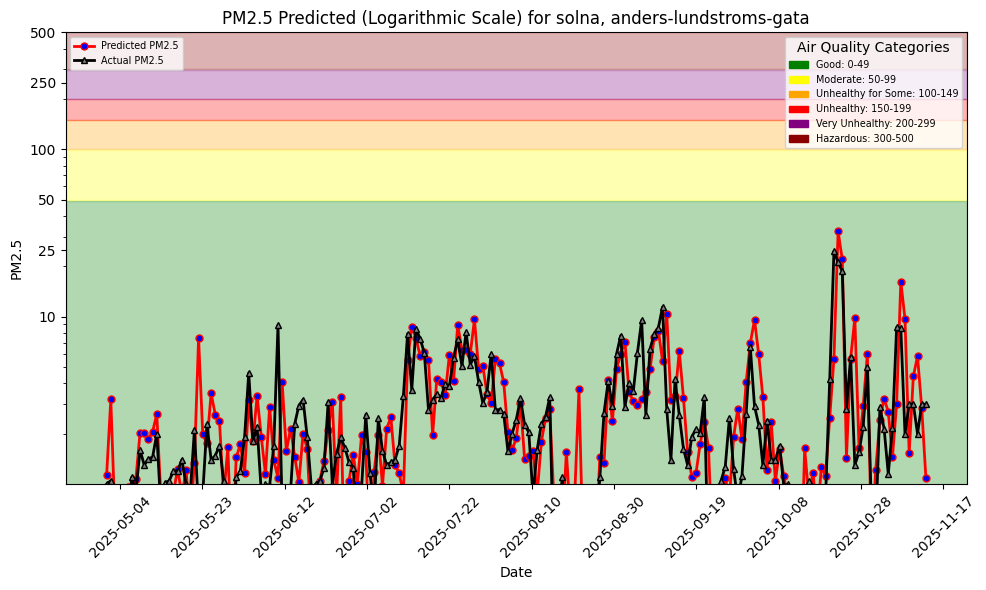

In [108]:
file_path = images_dir + "/pm25_hindcast_lagging.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

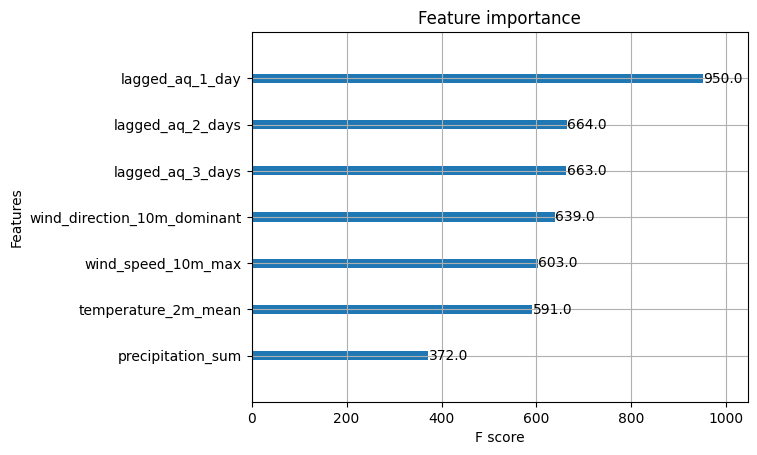

In [109]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance_lagging.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [110]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [111]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [112]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'
#Version 3 för del C
aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/5


Model(name: 'air_quality_xgboost_model', version: 5)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
